###  Adapting 2021 IPCC_AR6 (with ERF concept) GHG metric calculation to calculate dynamic AGWP/GWP/dynamic CF (DCF) for DLCA, seperating two notebooks:

<h4><li> CO2, CH4, and N2O </li></h4>
<h4><li> all other halocarbons </li></h4>

RAW calculation files: 
#pre-written modules: https://github.com/chrisroadmap/ar6/tree/main/src/ar6
#run GWP calculation: https://github.com/chrisroadmap/ar6/blob/main/notebooks/335_chapter7_generate_metrics.ipynb


AR6_CHP7_pp150: 
ERFs for the direct effect of well-mixed greenhouse gases (WMGHGs) are from the analytical formulae in section 7.3.2,
The global mean temperature 19 response is calculated from the ERF time series using an impulse response function (see Cross-Chapter
Box 7.1
Further details on data sources and processing are available in the chapter data table (Table 6.SM.1)

In [1]:
#pip install fair:  https://github.com/OMS-NetZero/FAIR/tree/master/fair
#FaIR takes emissions of greenhouse gases, aerosol and ozone precursors, and converts these into greenhouse gas concentrations, radiative forcing and temperature change.
from fair.forcing.ghg import meinshausen
from fair.defaults.thermal import q, d
from fair.defaults.carbon import a, tau as alpha_co2
#from tqdm.notebook import tqdm
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.interpolate import interp1d
from scipy.signal import fftconvolve
from scipy.integrate import cumtrapz
from scipy.stats import multivariate_normal, norm
import random

In [2]:
#import sys
#sys.path.append('./ar6-main')
from Clone_chrisroadmap.ar6.metrics.halogen_generic import halogen_analytical
from Clone_chrisroadmap.ar6.metrics.co2 import co2_analytical
from Clone_chrisroadmap.ar6.metrics.ch4 import ch4_analytical
from Clone_chrisroadmap.ar6.metrics.n2o import n2o_analytical
from Clone_chrisroadmap.ar6.metrics.gasser import carbon_cycle_adjustment

### Begin calculation_CO2

In [3]:
#Define baseline GHG concentrations  ppm/ppb
co2 = 409.9   
ch4 = 1866.3
n2o = 332.1

<h5>Below define tstep (time interval for calculation) and H (time horizon)</h5>

In [4]:
ts_per_year = 10    # use 1 yr for faster calculation, if tstep = 10, then each year further subdivide to 10 runs
H_max = 500  # default using 500 yr, TH_years

In [5]:
rf_co2, agwp_co2, agtp_co2, iagtp_co2 = co2_analytical(
    np.linspace(0, H_max, H_max * ts_per_year + 1),
    #np.linspace(0, H_max, int(H_max * ts_per_year) + 1),   # in case tstep not interger
    d=np.array([3.424102092311, 285.003477841911]),        #parameters used to calculate AGTP
    q = np.array([0.443767728883447, 0.313998206372015]),  
    co2=co2, n2o=n2o,
    a=np.array([0.2173, 0.2240, 0.2824, 0.2763]),   #parameters for AGWP, same a0/a1/a2/a3 as in AR5  
    alpha_co2=np.array([0, 394.4, 36.54, 4.304]),   #parameters for AGWP, same tau0/tau1/tau2/tau3 as in AR5 
    co2_ra = 0.05
)

<h5>Instantaneous RF and
    Cumulative RF (AGWP)</h5>

Text(0.5, 1.0, 'CRF_CO2')

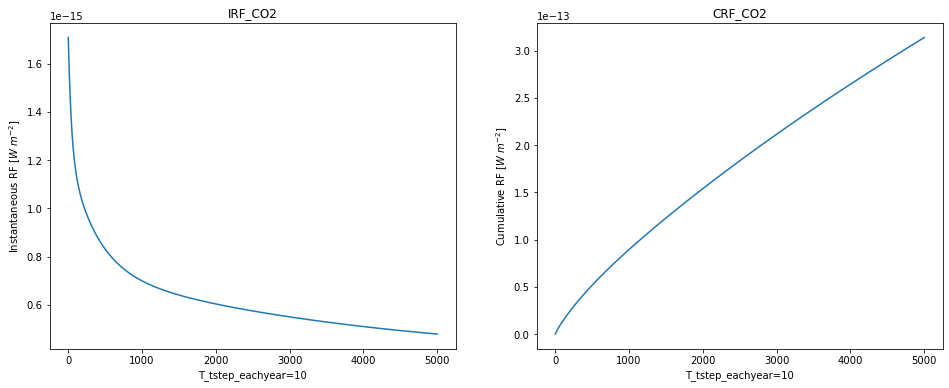

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

ax1.plot(rf_co2)
ax1.set(xlabel='T_tstep_eachyear=' + str(ts_per_year), ylabel= "Instantaneous RF [" + '$W \ m^{-2}$' + ']')
ax1.set_title('IRF_CO2')

ax2.plot(agwp_co2)
ax2.set(xlabel='T_tstep_eachyear=' + str(ts_per_year), ylabel= "Cumulative RF [" + '$W \ m^{-2}$' + ']')
ax2.set_title('CRF_CO2')

#Single plot output
#plt.plot(agwp_co2)
#plt.xlabel('Time', size=14)
#plt.ylabel("Cumulative RF [" + '$W \ m^{-2}$' + ']', size=14)

### Calculate AGWP
<li> AGWP == CRF when tstep=1 </li>

In [7]:
# When tstep == 1, final_agwp == agwp_co2
# When tstep != 1, final_agwp should be annual data, not same len(agwp_co2), each year has tstep, len(agwp_co2)=tstep*H_max
def agwp_t_co2(agwp_co2, tstep, HT):
    final_agwp = []
    if (tstep == 1):
        final_agwp = agwp_co2
    else: 
        for i in range(1,HT+1):
            final_agwp.append(agwp_co2[i * tstep])
        final_agwp.insert(0,0)  #insert 0 to the first element, so len is [501], same as H_max
    return final_agwp

In [8]:
final_agwp_co2 = agwp_t_co2(agwp_co2,ts_per_year,H_max)
#final_agwp_co2

In [9]:
print(len(range(H_max)), len(final_agwp_co2), len(agwp_co2)) #if tstep != 1, agwp_co2 != final_agwp
#comp = final_agwp_co2 == agwp_co2
#equal_arrays = comp.all()
#print(equal_arrays)   # final_agwp == agwp_co2 only when tstep == 1
#final_agwp 

500 501 5001


### SAVE AGWP to dataframe, use AGWP to calculate DCF
<h5><font color='red'>DCF = DIFF(AGWP[t]-AGWP[t-1]) </font></h5>

In [10]:
# No need to addin another col, index_col can be used directly to refer to YEAR[0-500]
#colname = []
#for i in range(len(final_agwp_co2)):  colname.append('TH_'+str(i))

In [11]:
DCF = np.diff(final_agwp_co2)
DCF = np.insert(DCF, 0, final_agwp_co2[0])  #insert the final_agwp[0] to DCF[0] so they same len
len(DCF)

501

In [12]:
CO2_AGWP = {'co2_AGWP[W/m2/kg]':final_agwp_co2, 'co2_DCF':DCF} 

In [13]:
CO2_DF = pd.DataFrame(CO2_AGWP)

In [14]:
CO2_DF[0:51]

,co2_AGWP[W/m2/kg],co2_DCF
0,0.000000e+00,0.000000e+00
1,1.650939e-15,1.650939e-15
2,3.200712e-15,1.549773e-15
3,4.667778e-15,1.467066e-15
4,6.066831e-15,1.399053e-15
5,7.409581e-15,1.342750e-15
6,8.705369e-15,1.295788e-15
7,9.961659e-15,1.256290e-15
8,1.118442e-14,1.222763e-15
9,1.237845e-14,1.194026e-15


### Begin calculation_CH4

In [15]:
rf_ch4, agwp_ch4, agtp_ch4, iagtp_ch4 = ch4_analytical(
    np.linspace(0, H_max, H_max * ts_per_year + 1),
    d=np.array([3.424102092311, 285.003477841911]),
    #q=np.array([0.443767728883447, 0.319591049742508]),    # this is what is in Zeb's file sent 25 Feb
    q = np.array([0.443767728883447, 0.313998206372015]),   # this is what Bill used
    co2=co2, ch4=ch4, n2o=n2o,
    ch4_ra = -0.14,
    alpha_ch4 = 11.8,
    ch4_o3=1.4e-4,
    ch4_h2o=0.00004
)

### For non-CO2, calculate the carbon cycle adjustment (per ERF concept)

In [16]:
rf_cc, agwp_cc, agtp_cc = carbon_cycle_adjustment(
    np.linspace(0, H_max, H_max * ts_per_year + 1),
    agtp_ch4,
    co2=co2,
    n2o=n2o,
    co2_ra = 0.05,
    d = np.array([3.424102092311, 285.003477841911]),
    q = np.array([0.443767728883447, 0.313998206372015]),   # this is what Bill used
)

Text(0.5, 1.0, 'CRF_CH4')

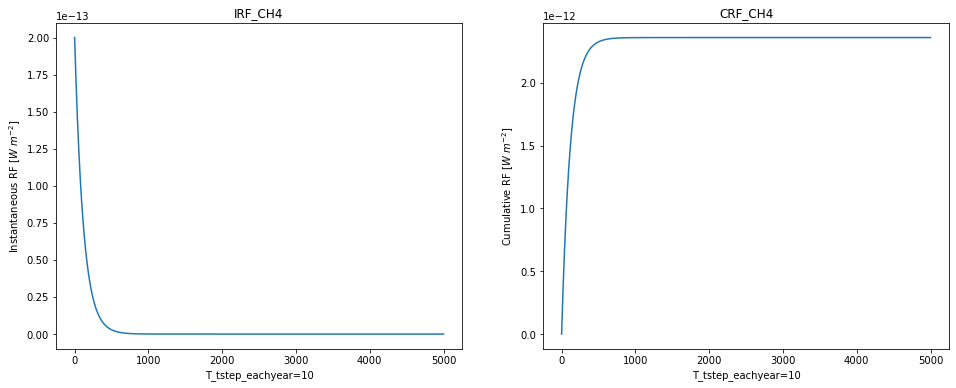

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(rf_ch4)
ax1.set(xlabel='T_tstep_eachyear=' + str(ts_per_year), ylabel= "Instantaneous RF [" + '$W \ m^{-2}$' + ']')
ax1.set_title('IRF_CH4')

ax2.plot(agwp_ch4)
ax2.set(xlabel='T_tstep_eachyear=' + str(ts_per_year), ylabel= "Cumulative RF [" + '$W \ m^{-2}$' + ']')
ax2.set_title('CRF_CH4')

<h4>agwp_t_ch4_n20 function to calculate annual AGWP, and GWP (AGWP[gas]/AGWP[CO2]) </h4>

In [20]:
def agwp_t_ch4_n20(agwp_self, agwp_cc, agwp_co2, tstep, HT):
    final_agwp = []
    final_gwp = []
    if len(agwp_self) == len(agwp_cc) == len(agwp_co2):
        for i in range(1,HT+1):
            final_agwp.append(agwp_self[i * tstep] + agwp_cc[i * tstep])     #agwp_n2o[20 * ts_per_year] + agwp_cc[20 * ts_per_year]
            final_gwp.append( (agwp_self[i * tstep]+agwp_cc[i * tstep])/agwp_co2[i * tstep] )
    else: 
        print("wrong input parameters")
    final_agwp.insert(0,0)  #insert 0 to the first element, so len is [501], same as H_max
    final_gwp.insert(0,0)
    
    return final_agwp, final_gwp

In [21]:
final_agwp_ch4, gwp_ch4 = agwp_t_ch4_n20(agwp_ch4, agwp_cc, agwp_co2, ts_per_year, H_max)

In [22]:
DCF_ch4 = np.diff(final_agwp_ch4)
DCF_ch4 = np.insert(DCF_ch4, 0, final_agwp_ch4[0])   

In [23]:
ch4_AGWP = {'ch4_AGWP[W/m2/kg]':final_agwp_ch4, 'ch4_DCF':DCF_ch4, 'ch4_GWP': gwp_ch4} 

In [24]:
ch4_DF = pd.DataFrame(ch4_AGWP)
ch4_DF

,ch4_AGWP[W/m2/kg],ch4_DCF,ch4_GWP
0,0.000000e+00,0.000000e+00,0.000000
1,1.917899e-13,1.917899e-13,116.170191
2,3.683228e-13,1.765328e-13,115.075247
3,5.310031e-13,1.626803e-13,113.759286
4,6.810170e-13,1.500139e-13,112.252506
...,...,...,...
496,2.495813e-12,-6.797041e-17,8.002421
497,2.495744e-12,-6.824435e-17,7.989905
498,2.495676e-12,-6.851727e-17,7.977434
499,2.495607e-12,-6.878919e-17,7.965006


#### when using tstep = 1, slightly diff. results as compared to tstep=10

In [25]:
print(ch4_DF['ch4_AGWP[W/m2/kg]'][20],ch4_DF['ch4_AGWP[W/m2/kg]'][100],ch4_DF['ch4_AGWP[W/m2/kg]'][500])

1.9760779442146506e-12 2.492428008209284e-12 2.495538028821586e-12


In [26]:
print(ch4_DF['ch4_GWP'][20],ch4_DF['ch4_GWP'][100],ch4_DF['ch4_GWP'][500])

81.19896116889024 27.859213994661 7.9526231404870575


### Begin calculation_N2O

In [27]:
rf_n2o, agwp_n2o, agtp_n2o, iagtp_n2o = n2o_analytical(
    np.linspace(0, H_max, H_max * ts_per_year + 1),
    d=np.array([3.424102092311, 285.003477841911]),
    q = np.array([0.443767728883447, 0.313998206372015]),   # this is what Bill used
    co2=co2, ch4=ch4, n2o=n2o
)

rf_cc, agwp_cc, agtp_cc = carbon_cycle_adjustment(
    np.linspace(0, H_max, H_max * ts_per_year + 1),
    agtp_n2o,
    co2=co2,
    n2o=n2o,
    co2_ra = 0.05,
    d = np.array([3.424102092311, 285.003477841911]),
    #q=np.array([0.443767728883447, 0.319591049742508]),    # this is what is in Zeb's file sent 25 Feb
    q = np.array([0.443767728883447, 0.313998206372015]),   # this is what Bill used
)

<b>(rf_cc, agwp_cc, agtp_cc) now overwrite those calculated for CH4, no worry value for CH4 already saved </b>

Text(0.5, 1.0, 'CRF_N2O')

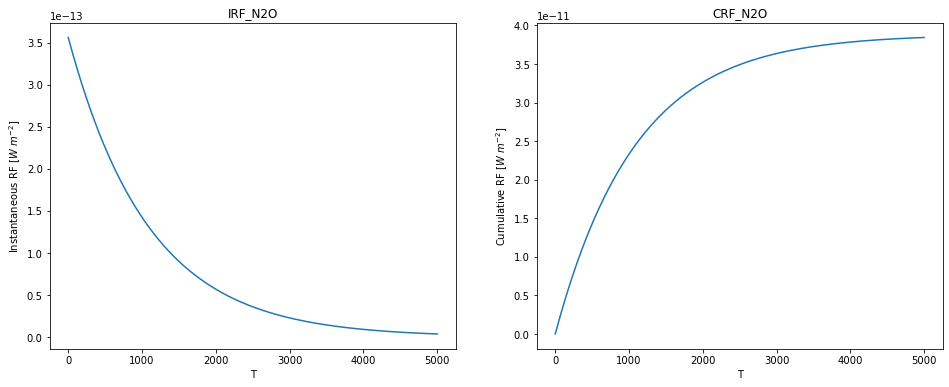

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(rf_n2o)
ax1.set(xlabel='T', ylabel= "Instantaneous RF [" + '$W \ m^{-2}$' + ']')
ax1.set_title('IRF_N2O')

ax2.plot(agwp_n2o)
ax2.set(xlabel='T', ylabel= "Cumulative RF [" + '$W \ m^{-2}$' + ']')
ax2.set_title('CRF_N2O')

In [29]:
final_agwp_n2o, gwp_n2o = agwp_t_ch4_n20(agwp_n2o, agwp_cc, agwp_co2, ts_per_year, H_max)

In [30]:
DCF_n2o = np.diff(final_agwp_n2o)
DCF_n2o = np.insert(DCF_n2o, 0, final_agwp_n2o[0])  #insert the final_agwp[0] to DCF[0] so they same len
len(DCF_n2o)

501

In [31]:
n2o_AGWP = {'n2o_AGWP[W/m2/kg]':final_agwp_n2o, 'n2o_DCF':DCF_n2o, 'n2o_GWP': gwp_n2o} 

In [32]:
n2o_DF = pd.DataFrame(n2o_AGWP)
n2o_DF

,n2o_AGWP[W/m2/kg],n2o_DCF,n2o_GWP
0,0.000000e+00,0.000000e+00,0.000000
1,3.547778e-13,3.547778e-13,214.894525
2,7.069171e-13,3.521393e-13,220.862439
3,1.056749e-12,3.498315e-13,226.392229
4,1.404406e-12,3.476576e-13,231.489270
...,...,...,...
496,4.069119e-11,3.447751e-15,130.469754
497,4.069460e-11,3.405542e-15,130.280158
498,4.069796e-11,3.363679e-15,130.091124
499,4.070128e-11,3.322159e-15,129.902650


#### when using tstep = 1, slightly diff. results as compared to tstep=10

In [33]:
print(n2o_DF['n2o_GWP'][20],n2o_DF['n2o_GWP'][100],n2o_DF['n2o_GWP'][500])

273.25549608275776 273.35062615382117 129.71473478279052


## Save CO2 CH4 N2O to excel, different sheet

In [34]:
writer = pd.ExcelWriter('Data_output/DCF_CO2_CH4_N2O.xlsx', engine='xlsxwriter')
# Write each dataframe to each worksheet.
CO2_DF.to_excel(writer, sheet_name='CO2')
ch4_DF.to_excel(writer, sheet_name='CH4')
n2o_DF.to_excel(writer, sheet_name='N2O')
writer.save()

## Crosscheck_Compare DCF[CO2/CH4/N2O] with that from DNY_CO2

<h4>CO2 has similar results (calculated here per AR6), only 2% difference to DCF from the DNY_CO2 tool </h4>
<p>for CO2, "crosscheck_calc.xlsx" has DCF calculated in excel </p>

In [77]:
DNYCO2_DCF = pd.read_excel('crosscheck_DCF_DNYCO2.xlsx', index_col=0) 
DNYCO2_DCF
#year 0 with all 0 value added to DNYCO2

,CO2,CH4,N2O,CO,CFC-11,CFC-12,CFC-13,CFC-113,CFC-114,CFC-115,...,"3,3,3-trifluoro-propanal",2-fluoroethanol,"2,2-difluoroethanol","2,2,2-trifluoroethanol","1,1'-oxybis[2-(difluoromethoxy)-1,1,2,2-tetrafluoroethane","1,1'-oxybis[2-(difluoromethoxy)-1,1,2,2-tetrafluoroethane.1","1,1,3,3,4,4,5,5,6,6,7,7,10,10,12,12-hexadecaluoro-2,5,8,11-tetraoxadodecane","1,1,3,3,4,4,6,6,7,7,9,9,10,10,12,12,13,13,15,15-eicosafluoro--2,5,8,11,14-pentaoxapentadecane",Methylene chloride (HCC-30),Methyl chloride (R-40)
Year,,,,,,,,,,,,,,,,,,,,,
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1.692382e-15,2.025996e-13,3.554679e-13,2.659458e-15,1.053473e-11,1.476585e-11,1.375207e-11,9.037014e-12,1.008756e-11,7.368190e-12,...,9.860000e-16,8.070000e-14,2.779697e-13,1.764717e-12,1.764717e-12,1.736693e-11,1.589039e-11,1.286700e-11,7.508545e-13,7.079750e-13
2,1.588676e-15,1.872409e-13,3.525422e-13,2.496492e-15,1.030320e-11,1.461893e-11,1.373060e-11,8.931319e-12,1.003460e-11,7.360970e-12,...,0.000000e+00,1.369016e-21,3.027334e-17,6.295449e-14,6.295449e-14,1.671166e-11,1.529083e-11,1.238151e-11,6.163389e-14,2.604495e-13
3,1.503893e-15,1.730541e-13,3.496407e-13,2.363260e-15,1.007677e-11,1.447347e-11,1.370917e-11,8.826860e-12,9.981928e-12,7.353757e-12,...,0.000000e+00,0.000000e+00,3.297032e-21,2.245838e-15,2.245838e-15,1.608110e-11,1.471388e-11,1.191434e-11,5.059218e-15,9.581400e-14
4,1.434173e-15,1.599516e-13,3.467630e-13,2.253700e-15,9.855309e-12,1.432945e-11,1.368776e-11,8.723623e-12,9.929530e-12,7.346551e-12,...,0.000000e+00,0.000000e+00,3.590857e-25,8.011801e-17,8.011801e-17,1.547434e-11,1.415871e-11,1.146480e-11,4.152859e-16,3.524800e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,3.831353e-16,1.053836e-15,2.456548e-20,6.020698e-16,0.000000e+00,3.199525e-20,6.089630e-13,5.793750e-22,2.777755e-16,1.042154e-12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1997,3.831290e-16,1.053818e-15,2.436329e-20,6.020599e-16,0.000000e+00,3.167660e-20,6.080122e-13,5.723993e-22,2.763173e-16,1.041133e-12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1998,3.831227e-16,1.053800e-15,2.416277e-20,6.020500e-16,0.000000e+00,3.136174e-20,6.070629e-13,5.658111e-22,2.748669e-16,1.040113e-12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


(0.0, 1.0)

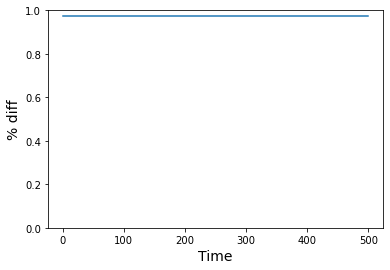

In [65]:
CO2_500DCF_diff = (CO2_DF['DCF_diff_AGWP'][0:500] / DNYCO2_DCF['CO2'][0:500])
plt.plot(CO2_500DCF_diff)
plt.xlabel('Time', size=14)
plt.ylabel('% diff', size=14)
plt.ylim(0,1)

In [66]:
CO2_500DCF_diff

0           NaN
1      0.975512
2      0.975512
3      0.975512
4      0.975512
         ...   
495    0.975512
496    0.975512
497    0.975512
498    0.975512
499    0.975512
Length: 500, dtype: float64

<h4>CH4 has <font color='red'>biggest changes</font> after using ERF in AR6 (instead of RF in AR1-AR5)</h4>

Text(0, 0.5, '% diff')

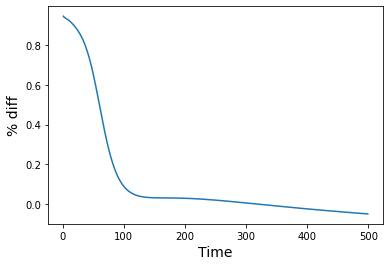

In [67]:
ch4_500DCF_diff = (ch4_DF['DCF_diff_AGWP'][0:500] / DNYCO2_DCF['CH4'][0:500])
plt.plot(ch4_500DCF_diff)
plt.xlabel('Time', size=14)
plt.ylabel('% diff', size=14)

In [68]:
ch4_500DCF_diff

0           NaN
1      0.946645
2      0.942811
3      0.940055
4      0.937870
         ...   
495   -0.049617
496   -0.049848
497   -0.050079
498   -0.050308
499   -0.050538
Length: 500, dtype: float64

<h4>N2O has relatively smaller changes than CH4</h4>

Text(0, 0.5, '% diff')

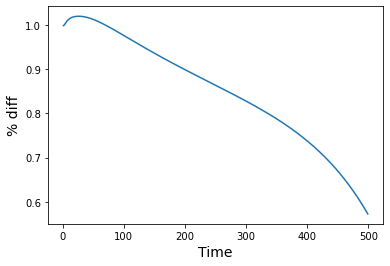

In [69]:
n2o_500DCF_diff = (n2o_DF['DCF_diff_AGWP'][0:500] / DNYCO2_DCF['N2O'][0:500])
plt.plot(n2o_500DCF_diff)
plt.xlabel('Time', size=14)
plt.ylabel('% diff', size=14)

In [70]:
list(n2o_500DCF_diff)

[nan,
 0.9980586205360025,
 0.9988571287997791,
 1.0005458825380844,
 1.0025799289614328,
 1.0046584460957877,
 1.0066266736875153,
 1.008415010747654,
 1.0100016877340485,
 1.0113902773884123,
 1.0125964566571033,
 1.013640466804525,
 1.0145430287221064,
 1.0153233098818264,
 1.0159980743956523,
 1.0165814863621407,
 1.0170852493706632,
 1.0175188972258404,
 1.0178901320424925,
 1.0182051547592266,
 1.018468961922697,
 1.018685599014855,
 1.018858369490965,
 1.018990003122911,
 1.019082789084758,
 1.0191386796320632,
 1.019159369904661,
 1.019146358728102,
 1.0191009945301401,
 1.019024509746821,
 1.0189180464239598,
 1.0187826751487852,
 1.0186194089715859,
 1.0184292135957302,
 1.0182130148085675,
 1.0179717038886555,
 1.0177061415405813,
 1.0174171607656395,
 1.01710556897251,
 1.0167721495475572,
 1.016417663047134,
 1.0160428481272312,
 1.0156484222934672,
 1.015235082530093,
 1.0148035058489968,
 1.0143543497865437,
 1.01388825286743,
 1.013405835048377,
 1.0129076981491423,
 1.

## plot IRF&CRF of CO2 CH4 N2O together 

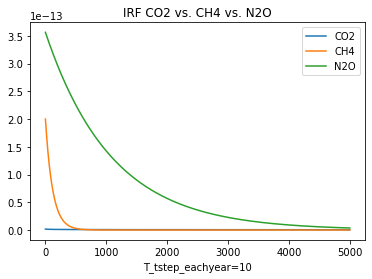

In [74]:
plt.plot(rf_co2, label = "CO2")
plt.plot(rf_ch4, label = "CH4")
plt.plot(rf_n2o, label = "N2O")
plt.title('IRF CO2 vs. CH4 vs. N2O')
plt.xlabel('T_tstep_eachyear=' + str(ts_per_year))
plt.legend()
plt.show()

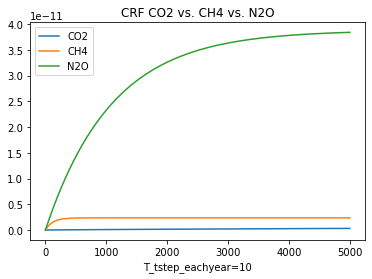

In [75]:
plt.plot(agwp_co2, label = "CO2")
plt.plot(agwp_ch4, label = "CH4")
plt.plot(agwp_n2o, label = "N2O")
plt.title('CRF CO2 vs. CH4 vs. N2O')
plt.xlabel('T_tstep_eachyear=' + str(ts_per_year))
plt.legend()
plt.show()

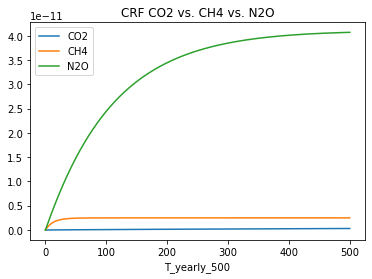

In [76]:
plt.plot(final_agwp_co2, label = "CO2")
plt.plot(final_agwp_ch4, label = "CH4")
plt.plot(final_agwp_n2o, label = "N2O")
plt.title('Annual CRF (AGWP) CO2 vs. CH4 vs. N2O')
plt.xlabel('T_yearly_' + str(H_max))
plt.legend()
plt.show()

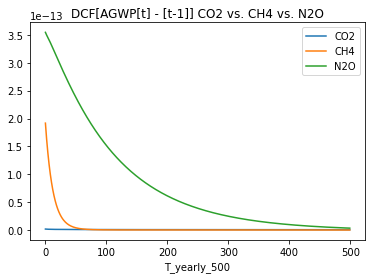

In [92]:
# DCF plot look similar to IRF  
plt.plot(np.delete(DCF, 0), label = "CO2")      # delete year0 [=0]
plt.plot(np.delete(DCF_ch4, 0), label = "CH4")
plt.plot(np.delete(DCF_n2o, 0), label = "N2O")
plt.title('DCF[AGWP[t]-[t-1]] CO2 vs. CH4 vs. N2O')
plt.xlabel('T_yearly_' + str(H_max))
plt.legend()
plt.show()

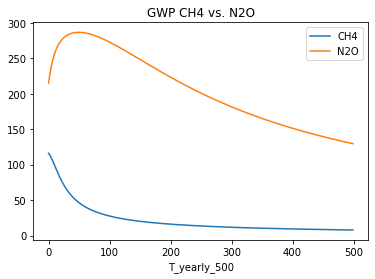

In [91]:
plt.plot(np.delete(gwp_ch4,0), label = "CH4")   # delete year0 [=0]
plt.plot(np.delete(gwp_n2o,0), label = "N2O")
plt.title('GWP CH4 vs. N2O')
plt.xlabel('T_yearly_' + str(H_max))
plt.legend()
plt.show()